In [30]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import *
sys.path.append('/data/nihaifeng/code/HeliosArtifact/simulator')
import utils

sns.set_style("ticks")
font = {
    "font.family": "Roboto",
    "font.size": 12,
}
sns.set_style(font)
paper_rc = {
    "lines.linewidth": 2.5,
    "lines.markersize": 10,
}
sns.set_context("paper", font_scale=1.6, rc=paper_rc)
current_palette = sns.color_palette()

Load Data df

In [ ]:
data_name = ['PAI', 'Philly',  'Venus']
trace_dfs = []

data_dir = './data/'
for idx, data in enumerate(data_name):
	if data == 'Philly':
		trace_dir = data_dir + data
		vc_dict = pd.read_pickle(data_dir + data + '/vc_dict_homo.pkl')
		trace_range = ('2017-10-01 00:00:00', '2017-11-30 23:59:00')
		trace_df, start_ts = utils.trace_philly_process(trace_dir, trace_range, vc_dict, need_mutation=True)
	elif data == 'PAI':
		vc_dict = pd.read_pickle(data_dir + 'ali20/vc_dict_homo.pkl')
		trace_dir = data_dir + 'ali20'
		trace_df, _ = utils.trace_ali20_process(trace_dir)
	elif data == 'Venus':
		vc_dict = pd.read_pickle(data_dir + data + '/vc_dict_homo.pkl')
		trace_dir = data_dir + data
		trace_range = ('2020-09-01 00:00:00', '2020-09-26 23:59:00')
		trace_df, _ = utils.trace_process(trace_dir, trace_range, vc_dict)
	trace_dfs.append(trace_df)

Draw Job GPU Num CDF

Draw Job Duration Time CDF

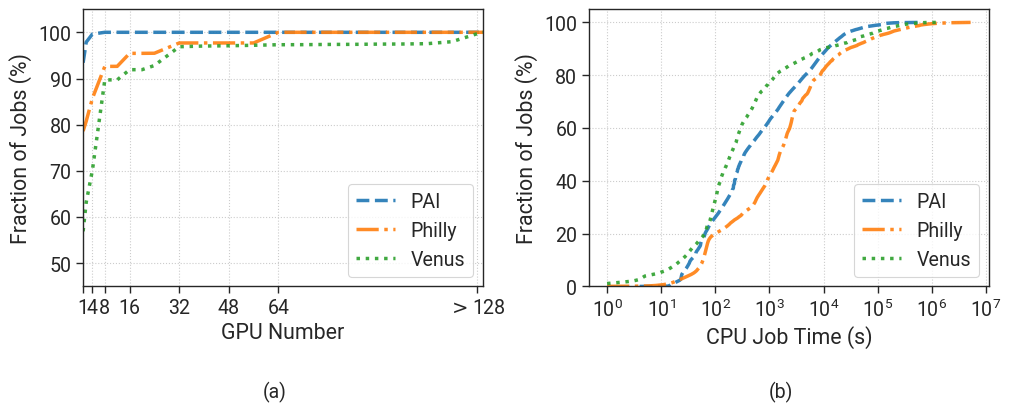

In [75]:
fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, constrained_layout=True, figsize=(10, 4))

linestyles = ["--", "-.", ":", "--"]

for idx, trace_df in enumerate(trace_dfs):
	# GPU Ratio
	gpu_counter = trace_df.gpu_num.value_counts()
	gpu_counter.sort_index(inplace=True)
	
	gpu = [1,2,4,8,12,16,20,24,32,40,48,56,64,72,80,88,96,104,112,120,128,130]
	values = [0 for _ in range(len(gpu))]
	for k, v in gpu_counter.items():
		if k <= 128:
			values[gpu.index(k)] = v
		else:
			values[-1] += v
	gpu_cdf = np.cumsum(values) / sum(values) * 100

	# Duration Ratio
	duration_counter = trace_df.duration.value_counts()
	duration_counter.sort_index(inplace=True)
	duration_index = duration_counter.index
	duration_value = duration_counter.values
	y_cdf = np.cumsum(duration_value) / sum(duration_value) * 100

	ax1.plot(gpu, gpu_cdf, linestyles[idx], alpha=0.9, label=data_name[idx])

	ax2.plot(duration_index, y_cdf, linestyles[idx], alpha=0.9, label=data_name[idx])

ax1.set_xlabel(f"GPU Number")
ax1.set_ylabel(f"Fraction of Jobs (%)")
xticks = [1, 4, 8, 16, 32, 48, 64, 128]
ax1.set_xticks(xticks)
ax1.set_xticklabels([1, 4, 8, 16, 32, 48, 64, "$>$128"])
ax1.set_xlim(1, gpu[-1])
ax1.set_ylim(45, 105)
ax1.legend(loc="lower right")
ax1.text(0.45, -0.4, "(a)", transform=ax1.transAxes, size=14)
ax1.grid(linestyle=":")

ax2.set_xlabel(f"CPU Job Time (s)")
ax2.set_ylabel(f"Fraction of Jobs (%)")
ax2.set_xscale("log")
ax2.set_xticks([1e0, 1e1, 1e2, 1e3, 1e4, 1e5, 1e6, 1e7])
ax2.set_ylim(0, 105)
ax2.legend(loc="lower right")
ax2.grid(linestyle=":")
ax2.text(0.45, -0.4, "(b)", transform=ax2.transAxes, size=14)

save = False
if save:
	fig.savefig(
		f"./job_cdf_jobtime.pdf", bbox_inches="tight", dpi=600,
	)